# Proximal Algorithm in Wasserstein Spaces

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
import copy
import sys
from utils import *
from nn_structure import *
# Learning rate of otmap should be smaller than 0.003.

sys.argv = ['notebook']
# '--ndata', '80', '--m', '200','--iters_lr','300',"--steps_eta","35",'--lr_otmap','0.002','--print_freq','100','--eta',"0.1"
parser = argparse.ArgumentParser()
parser.add_argument("--d", type=int, default=2) 
parser.add_argument("--ndata", type=int, default=80) # number of data points 
parser.add_argument("--m", type=int, default=100) # width of neural network
parser.add_argument("--iters_lr", type=int, default=300) # iterations of the inner loop
parser.add_argument("--steps_eta", type=int, default=40) # iterations of the outer loop, the steps for optimizing the two-layer NN
parser.add_argument("--lr_otmap", type=float, default=0.002) # learning rate for optimizing OT map
parser.add_argument("--eta", type=float, default=0.1) # step size of optimize the two-layer NN
parser.add_argument("--tau", type=float, default=0.02)
parser.add_argument("--print_freq", type=int, default=100)
opt=parser.parse_args()


In [43]:
print(opt.d)
print(opt.tau)

2
0.02


## 1 Basic Comparisons

In [44]:

X_train,y_train_truth=generate_data(opt)
weights_gd=torch.randn(opt.m,opt.d+1)

weights_ot=weights_gd.clone().detach()
weights_gd_noise=weights_gd.clone().detach()
weights_ot_noise=weights_gd.clone().detach()
train_losses_gd,_=optimize_nn(opt,X_train,y_train_truth,weights_gd,noise_gd=False)
train_losses_ot,_=optimize_nn_withOT(opt, X_train,y_train_truth,weights_ot,noise_gd=False)
train_losses_gd_noise,negs_gd_noise=optimize_nn(opt,X_train,y_train_truth,weights_gd_noise,noise_gd=True)
train_losses_ot_noise,negs_ot_noise=optimize_nn_withOT(opt, X_train,y_train_truth,weights_ot_noise,noise_gd=True)



torch.Size([100, 2])
Steps_eta  0 --- NN Loss tensor(2.5404)
Total loss tensor(8.7571, grad_fn=<AddBackward0>)
Total loss tensor(2.1474, grad_fn=<AddBackward0>)
Total loss tensor(2.1324, grad_fn=<AddBackward0>)
Steps_eta  1 --- NN Loss tensor(1.7819)
Total loss tensor(7.1716, grad_fn=<AddBackward0>)
Total loss tensor(1.4878, grad_fn=<AddBackward0>)
Total loss tensor(1.4815, grad_fn=<AddBackward0>)
Steps_eta  2 --- NN Loss tensor(1.2211)
Total loss tensor(9.8532, grad_fn=<AddBackward0>)
Total loss tensor(1.0206, grad_fn=<AddBackward0>)
Total loss tensor(1.0145, grad_fn=<AddBackward0>)
Steps_eta  3 --- NN Loss tensor(0.8480)
Total loss tensor(9.1067, grad_fn=<AddBackward0>)
Total loss tensor(0.7249, grad_fn=<AddBackward0>)
Total loss tensor(0.7216, grad_fn=<AddBackward0>)
Steps_eta  4 --- NN Loss tensor(0.6185)
Total loss tensor(11.1880, grad_fn=<AddBackward0>)
Total loss tensor(0.5453, grad_fn=<AddBackward0>)
Total loss tensor(0.5425, grad_fn=<AddBackward0>)
Steps_eta  5 --- NN Loss ten

**Plot for GD and Backward GD**

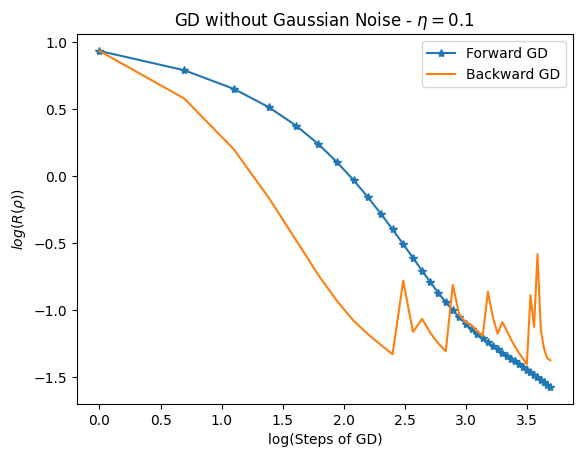

In [80]:
fig, ax = plt.subplots()

ax.plot(np.log(np.array(range(opt.steps_eta))+1),np.log(train_losses_gd),marker='*')
ax.plot(np.log(np.array(range(opt.steps_eta))+1),np.log(train_losses_ot))
plt.legend(['Forward GD','Backward GD'])
plt.xlabel("log(Steps of GD)")
plt.ylabel("$log(R(\\rho))$")
plt.title("GD without Gaussian Noise - "+"$\\eta=$"+str(opt.eta))
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.array(range(opt.steps_eta)),np.log(train_losses_gd),marker='*')
ax.plot(np.array(range(opt.steps_eta)),np.log(train_losses_ot))
plt.legend(['Forward GD','Backward GD'])
plt.xlabel("Steps of GD")
plt.ylabel("$log(R(\\rho))$")
plt.title("GD without Gaussian Noise - "+"$\\eta=$"+str(opt.eta))
plt.show()

**Plot for Noisy GD and Noisy Backward GD**

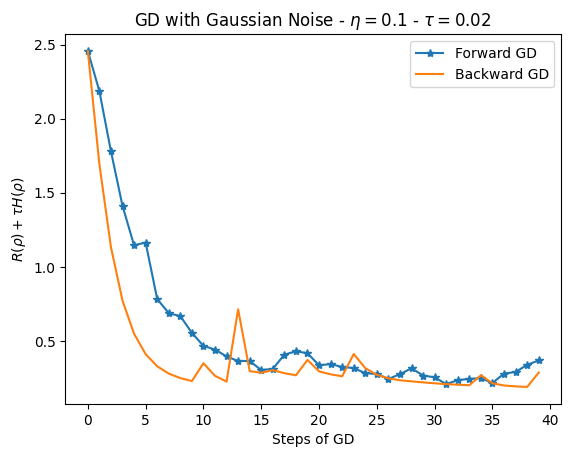

In [46]:
fig, ax = plt.subplots()
ax.plot(range(opt.steps_eta),np.array(train_losses_gd_noise)+opt.tau*np.array(negs_gd_noise),marker='*')
ax.plot(range(opt.steps_eta),np.array(train_losses_ot_noise)+opt.tau*np.array(negs_ot_noise))
plt.legend(['Forward GD','Backward GD'])
plt.xlabel("Steps of GD")
plt.ylabel("$R(\\rho)+\\tau H(\\rho)$")
plt.title("GD with Gaussian Noise - "+"$\\eta=$"+str(opt.eta)+" - $\\tau=$"+str(opt.tau))
plt.show()

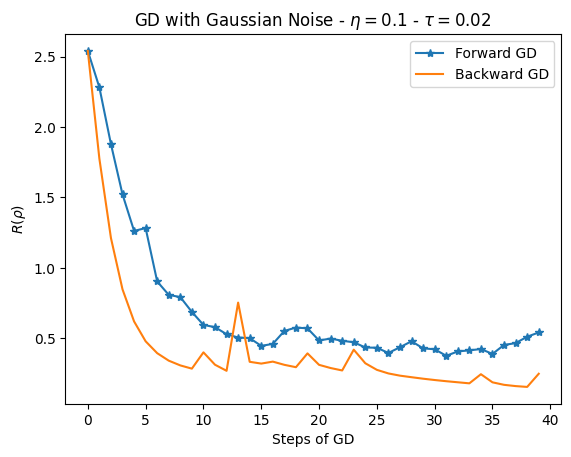

In [47]:
fig, ax = plt.subplots()
ax.plot(range(opt.steps_eta),np.array(train_losses_gd_noise),marker='*')
ax.plot(range(opt.steps_eta),np.array(train_losses_ot_noise))
plt.legend(['Forward GD','Backward GD'])
plt.xlabel("Steps of GD")
plt.ylabel("$R(\\rho)$")
plt.title("GD with Gaussian Noise - "+"$\\eta=$"+str(opt.eta)+" - $\\tau=$"+str(opt.tau))
plt.show()

In [14]:
print(train_losses_gd_noise)

[0.5034036040306091, 0.5299748778343201, 0.479076087474823, 0.43012118339538574, 0.38889867067337036, 0.3774944543838501, 0.28563594818115234, 0.3469529151916504, 0.3291216194629669, 0.25162750482559204, 0.261518657207489, 0.2064351588487625, 0.15429021418094635, 0.1543041169643402, 0.12302178144454956, 0.11165044456720352, 0.09747620671987534, 0.10340598970651627, 0.1148076206445694, 0.1114790216088295, 0.1186365932226181, 0.10986310243606567, 0.10605402290821075, 0.10772000253200531, 0.10749877989292145, 0.13005712628364563, 0.11454544961452484, 0.14882434904575348, 0.1779702752828598, 0.17265793681144714, 0.18237857520580292, 0.22172904014587402, 0.17822623252868652, 0.1566958725452423, 0.1434473693370819, 0.13810290396213531, 0.11334611475467682, 0.10593625158071518, 0.13650421798229218, 0.1508001834154129]


## 2 The influence of $\tau$ on Forward and Backward Algorithms

In [68]:
X_train,y_train_truth=generate_data(opt)
weights_gd=torch.randn(opt.m,opt.d+1)


**Forward Algorithm**

In [69]:
train_losses_gd_noise_array=[]
negs_gd_noise_array=[]

for tau in [0,0.05,0.1]:
    opt.tau=tau
    weights_gd_noise=weights_gd.clone().detach()
    train_losses_gd_noise,negs_gd_noise=optimize_nn(opt,X_train,y_train_truth,weights_gd_noise,noise_gd=True)
    train_losses_gd_noise_array.append(train_losses_gd_noise)
    negs_gd_noise_array.append(negs_gd_noise)  

    # plt.plot(negs_gd_noise, label = 'Forward GD - $\\tau=$'+str(tau),marker='*')
    # weights_ot_noise=weights_gd.clone().detach()
    # train_losses_ot_noise,negs_ot_noise=optimize_nn_withOT(opt, X_train,y_train_truth,weights_ot_noise,noise_gd=True)


torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])


In [ ]:

iter=0
for tau in [0,0.05,0.10]:
    plt.plot(train_losses_gd_noise_array[iter]+tau*np.array(negs_gd_noise_array[iter]), label = 'Forward Algorithm - $\\tau=$'+str(tau),marker='*')
    iter=iter+1
legend = plt.legend(loc = 1, shadow = True)
plt.ylabel('$R(\\rho)+\\tau R(\\rho)$')
plt.xlabel('Steps of Algorithm')
plt.title('Influence of $\\tau$ on Forward Algorithms')


Text(0.5, 1.0, 'Influence of $\\tau$ on Forward Algorithms')

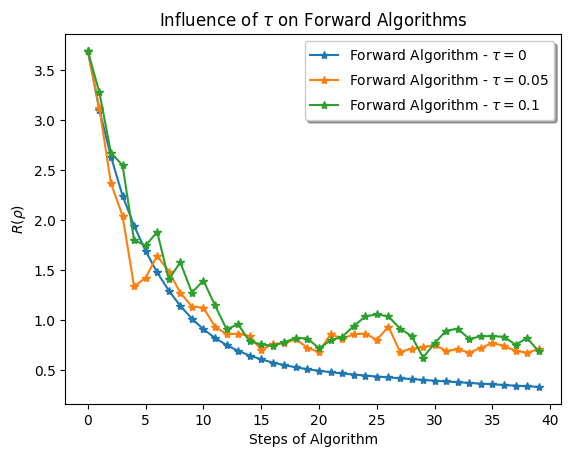

In [76]:

iter=0
for tau in [0,0.05,0.10]:
    plt.plot(train_losses_gd_noise_array[iter], label = 'Forward Algorithm - $\\tau=$'+str(tau),marker='*')
    iter=iter+1
legend = plt.legend(loc = 1, shadow = True)
plt.ylabel('$R(\\rho)$')
plt.xlabel('Steps of Algorithm')
plt.title('Influence of $\\tau$ on Forward Algorithms')

**Backward Algorithms**

In [35]:
train_losses_ot_noise_array=[]
negs_ot_noise_array=[]
for tau in [0,0.05,0.10]:
    opt.tau=tau
    weights_ot_noise=weights_gd.clone().detach()
    train_losses_ot_noise,negs_ot_noise=optimize_nn_withOT(opt, X_train,y_train_truth,weights_ot_noise,noise_gd=True)
    train_losses_ot_noise_array.append(train_losses_ot_noise)
    negs_ot_noise_array.append(negs_ot_noise)


Steps_eta  0 --- NN Loss tensor(2.5447)
Total loss tensor(7.1755, grad_fn=<AddBackward0>)
Total loss tensor(2.0665, grad_fn=<AddBackward0>)
Steps_eta  1 --- NN Loss tensor(1.6591)
Total loss tensor(7.2261, grad_fn=<AddBackward0>)
Total loss tensor(1.3465, grad_fn=<AddBackward0>)
Steps_eta  2 --- NN Loss tensor(1.0864)
Total loss tensor(10.4193, grad_fn=<AddBackward0>)
Total loss tensor(0.8912, grad_fn=<AddBackward0>)
Steps_eta  3 --- NN Loss tensor(0.7327)
Total loss tensor(13.1978, grad_fn=<AddBackward0>)
Total loss tensor(0.6213, grad_fn=<AddBackward0>)
Steps_eta  4 --- NN Loss tensor(0.5254)
Total loss tensor(9.8196, grad_fn=<AddBackward0>)
Total loss tensor(0.4596, grad_fn=<AddBackward0>)
Steps_eta  5 --- NN Loss tensor(0.4016)
Total loss tensor(11.2094, grad_fn=<AddBackward0>)
Total loss tensor(0.3673, grad_fn=<AddBackward0>)
Steps_eta  6 --- NN Loss tensor(0.3320)
Total loss tensor(12.4614, grad_fn=<AddBackward0>)
Total loss tensor(0.4981, grad_fn=<AddBackward0>)
Steps_eta  7 ---

Text(0.5, 1.0, 'Influence of $\\tau$ on Backward Algorithms')

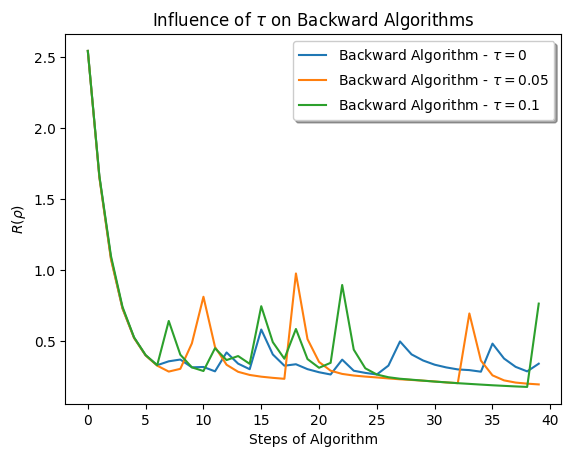

In [36]:
iter=0
for tau in [0,0.05,0.10]:
    plt.plot(train_losses_ot_noise_array[iter], label = 'Backward Algorithm - $\\tau=$'+str(tau))
    iter=iter+1
legend = plt.legend(loc = 1, shadow = True)
plt.ylabel('$R(\\rho)$')
plt.xlabel('Steps of Algorithm')
plt.title('Influence of $\\tau$ on Backward Algorithms')